In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [119]:
# Load data
df = pd.read_csv('data.csv')

# Handle potential datetime column and index
# if 'datetime' in df.columns:
#     df.set_index('datetime', inplace=True)  # Set datetime as index (if necessary)
if 'index' in df.columns:
    df.drop('index', axis=1, inplace=True, errors='ignore')  # Drop unnecessary index



In [120]:
df

,datetime,YEAR,DOY,HR,"BZ, nT (GSM)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.),"Dst-index, nT",f10.7_index,Vtec
0,2022-01-01 00:00:00,2022,1,0,-4.0,5.4,389.0,2.3,48,6,90.8,3.00
1,2022-01-01 01:00:00,2022,1,1,0.4,4.7,390.0,2.3,48,-3,90.8,2.95
2,2022-01-01 02:00:00,2022,1,2,-4.1,2.1,454.0,2.3,48,-7,90.8,2.77
3,2022-01-01 03:00:00,2022,1,3,-8.4,2.7,466.0,4.0,48,-13,90.8,2.57
4,2022-01-01 04:00:00,2022,1,4,-4.4,1.9,454.0,4.0,48,-21,90.8,3.78
...,...,...,...,...,...,...,...,...,...,...,...,...
20611,2024-05-08 19:00:00,2024,129,19,1.1,2.8,469.0,0.7,173,1,231.4,29.56
20612,2024-05-08 20:00:00,2024,129,20,1.7,2.9,460.0,0.7,173,-1,231.4,17.54
20613,2024-05-08 21:00:00,2024,129,21,1.5,2.8,458.0,1.0,173,2,231.4,7.37
20614,2024-05-08 22:00:00,2024,129,22,0.7,2.8,457.0,1.0,173,3,231.4,10.47


In [121]:
counts = df['Vtec'].value_counts()
counts

Vtec
21.550507    1665
14.845050     396
26.960237      52
4.250000       20
3.110000       20
             ... 
45.330000       1
29.760000       1
0.850000        1
33.310000       1
39.860000       1
Name: count, Length: 5119, dtype: int64

In [122]:
import pandas as pd
import numpy as np

# Set a small tolerance value
tolerance = 1e-6

# Filter rows where Vtec is close to 21.550507 within the tolerance
rows_to_drop = df[np.isclose(df['Vtec'], 21.550507, atol=tolerance)]

# Number of rows to drop
n_to_drop = 500  # Adjust this as needed

# Check if there are enough rows to drop
if len(rows_to_drop) < n_to_drop:
    raise ValueError(f"Cannot drop {n_to_drop} rows; only {len(rows_to_drop)} available.")

# Randomly select rows to drop
rows_to_drop_sampled = rows_to_drop.sample(n=n_to_drop, random_state=42)

# Drop the selected rows from the original DataFrame
df = df.drop(rows_to_drop_sampled.index)

# Check the new DataFrame
print(df['Vtec'].value_counts())


Vtec
21.550507    1165
14.845050     396
26.960237      52
4.250000       20
3.110000       20
             ... 
45.330000       1
29.760000       1
0.850000        1
33.310000       1
39.860000       1
Name: count, Length: 5119, dtype: int64


In [123]:
import pandas as pd
import numpy as np

# Set a small tolerance value
tolerance = 1e-6

# Filter rows where Vtec is close to 21.550507 within the tolerance
rows_to_drop = df[np.isclose(df['Vtec'], 14.845050, atol=tolerance)]

# Number of rows to drop
n_to_drop = 200  # Adjust this as needed

# Check if there are enough rows to drop
if len(rows_to_drop) < n_to_drop:
    raise ValueError(f"Cannot drop {n_to_drop} rows; only {len(rows_to_drop)} available.")

# Randomly select rows to drop
rows_to_drop_sampled = rows_to_drop.sample(n=n_to_drop, random_state=42)

# Drop the selected rows from the original DataFrame
df = df.drop(rows_to_drop_sampled.index)

# Check the new DataFrame
print(df['Vtec'].value_counts())


Vtec
21.550507    1165
14.845050     196
26.960237      52
4.250000       20
3.110000       20
             ... 
45.330000       1
29.760000       1
0.850000        1
33.310000       1
39.860000       1
Name: count, Length: 5119, dtype: int64


In [124]:
# Feature selection with domain knowledge
# (Replace with your domain-specific feature selection logic)
selected_features = ['YEAR', 'DOY', 'HR','Kp index','R (Sunspot No.)','f10.7_index']  # Replace with relevant features
X = df[selected_features]
Y = df['Vtec']

In [125]:
# Split data into train and test sets (consider stratified splitting for imbalanced data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)

# Normalize data using robust scaler for potential outliers
scaler_X = MinMaxScaler(feature_range=(0, 1))  # Adjust range for specific use cases
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1))

In [126]:
# Apply PCA with explained variance ratio determination
pca = PCA(n_components=0.95)  # Adjust based on desired information retention
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Number of features after PCA
features_pca = X_train_pca.shape[1]


In [127]:
look_back = 10  # Adjust look_back based on data patterns and experiment

def create_sequences(data, look_back):
    sequences = [data[i:i + look_back] for i in range(len(data) - look_back)]
    return np.array(sequences)

# Create sequences
X_train_sequences = create_sequences(X_train_pca, look_back)
X_test_sequences = create_sequences(X_test_pca, look_back)

# Create target sequences
Y_train_sequences = create_sequences(Y_train_scaled, look_back)
Y_test_sequences = create_sequences(Y_test_scaled, look_back)

# Adjust target sequences to match input sequences (consider multi-step forecasting)
Y_train_sequences = Y_train_sequences[:, -1, 0]  # Last value in the sequence
Y_test_sequences = Y_test_sequences[:, -1, 0]   # Last value in the sequence


# Training the models 

## Model 1

In [128]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [129]:
checkpoint_path = "model_weights.keras"


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # or 'val_accuracy', depending on what you want to monitor
    save_best_only=True,  # Save only the best model weights
    mode='min',  # 'min' for loss (lower is better), 'max' for accuracy (higher is better)
    verbose=1  # Verbosity mode
)

In [130]:
from tensorflow.keras.layers import Bidirectional, GRU,Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention, Concatenate

# Define input layers
input_layer = Input(shape=(look_back, features_pca))

# Bidirectional GRU layer
gru_output = Bidirectional(GRU(units=50, return_sequences=True))(input_layer)

# Attention mechanism
attention = Attention()([gru_output, gru_output])
context_vector = Concatenate()([gru_output, attention])

# Add GRU and Dense layers
gru_output = GRU(units=25, return_sequences=False)(context_vector)
output_layer = Dense(1,activation='linear')(gru_output)

model_1 = Model(inputs=input_layer, outputs=output_layer)


model_1.compile(optimizer='adam', loss='mean_squared_error')


In [131]:
#  GRU 85 Need early stopping
#  CNN 72 100 epcoh
#

In [132]:
model_1.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 10, 100)   │     17,100 │ input_layer_11[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 10, 100)   │          0 │ bidirectional_9[… │
│ (Attention)         │                   │            │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10, 200)   │          0 │ bidirectional_9[… │
│ (Concatenate)       │                   │            │ attention_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 25)        │     17,025 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         26 │ gru_19[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,151 (133.40 KB)

 Trainable params: 34,151 (133.40 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# Train the model
history = model_1.fit(X_train_sequences, Y_train_sequences,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback]  # Include the callback here
) 

Epoch 1/50
467/473 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254
Epoch 1: val_loss improved from inf to 0.01115, saving model to model_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0253 - val_loss: 0.0112
Epoch 2/50
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 2: val_loss improved from 0.01115 to 0.01046, saving model to model_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 3/50
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 3: val_loss improved from 0.01046 to 0.00942, saving model to model_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 4/50
468/473 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090
Epoch 4: val_loss improved from 0.00942 to 0.00784, saving model to model_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 5/50
469/473 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 5: val_los

### Evaluation 1

591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Mean Squared Error: 26.862803348083556
Training R² Score: 0.875864569925438
Test Mean Squared Error: 34.0790701404754
Test R² Score: 0.81806399312059


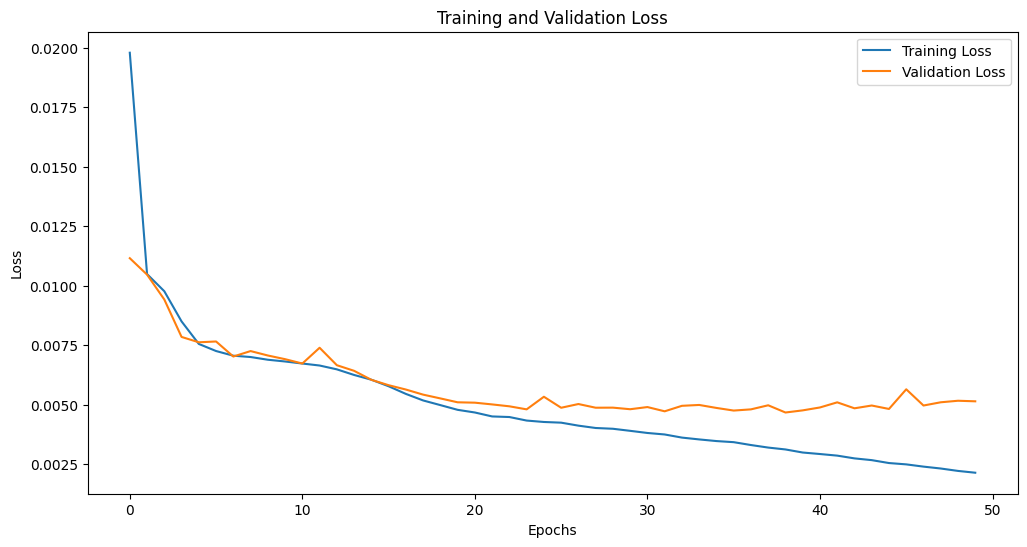

In [134]:
model_1.load_weights(checkpoint_path)

# Predict on training and test data
Y_train_pred = model_1.predict(X_train_sequences)
Y_test_pred = model_1.predict(X_test_sequences)

# Inverse transform predictions
Y_train_inv = scaler_Y.inverse_transform(Y_train_sequences.reshape(-1, 1))
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_test_inv = scaler_Y.inverse_transform(Y_test_sequences.reshape(-1, 1))
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)

# Calculate metrics
mse_train = mean_squared_error(Y_train_inv, Y_train_pred_inv)
r2_train = r2_score(Y_train_inv, Y_train_pred_inv)
mse_test = mean_squared_error(Y_test_inv, Y_test_pred_inv)
r2_test = r2_score(Y_test_inv, Y_test_pred_inv)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R² Score: {r2_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R² Score: {r2_test}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model 2

In [135]:
checkpoint2_path = "model2_weights.keras"


checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint2_path,
    monitor='val_loss',  # or 'val_accuracy', depending on what you want to monitor
    save_best_only=True,  # Save only the best model weights
    mode='min',  # 'min' for loss (lower is better), 'max' for accuracy (higher is better)
    verbose=1  # Verbosity mode
)

In [136]:
from tensorflow.keras.layers import Bidirectional, GRU

model_2 = Sequential()
model_2.add(Bidirectional(GRU(units=50, return_sequences=True), input_shape=(look_back, features_pca)))
model_2.add(GRU(units=25, return_sequences=False))
model_2.add(Dense(1,activation='linear'))
model_2.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [137]:
model_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 10, 100)        │        17,100 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 25)             │         9,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,651 (104.11 KB)

 Trainable params: 26,651 (104.11 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Train the model
history = model_2.fit(X_train_sequences, Y_train_sequences,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback2]  # Include the callback here
) 

Epoch 1/50
470/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0251
Epoch 1: val_loss improved from inf to 0.01054, saving model to model2_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0250 - val_loss: 0.0105
Epoch 2/50
466/473 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105
Epoch 2: val_loss improved from 0.01054 to 0.01003, saving model to model2_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 3/50
469/473 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097
Epoch 3: val_loss improved from 0.01003 to 0.00901, saving model to model2_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 4/50
471/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 4: val_loss improved from 0.00901 to 0.00756, saving model to model2_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 5/50
469/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 5: val_

### Evaluation 2

591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Mean Squared Error: 25.34982299270286
Training R² Score: 0.8828561882117307
Test Mean Squared Error: 27.613551004575072
Test R² Score: 0.8525810949411301


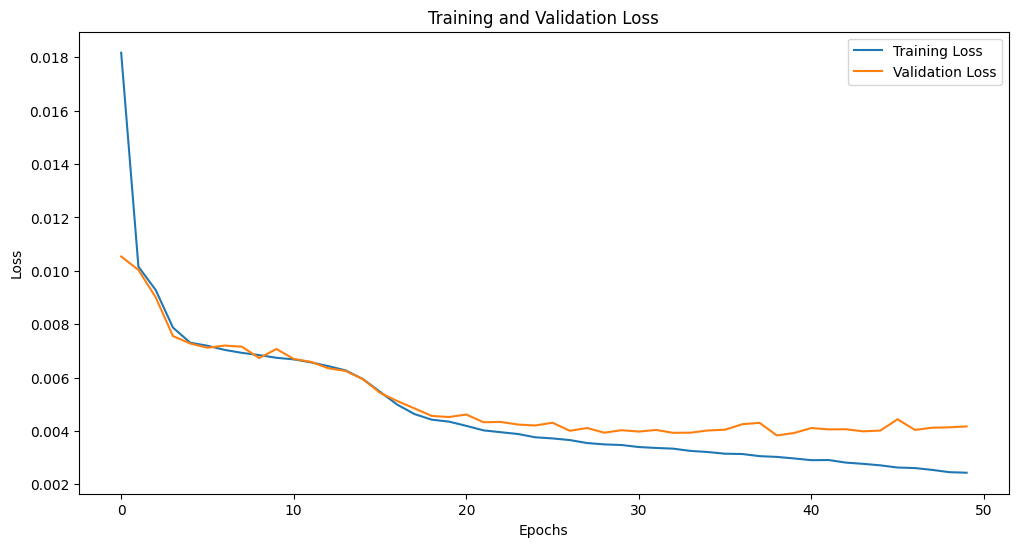

In [139]:
model_2.load_weights(checkpoint2_path)

# Predict on training and test data
Y_train_pred = model_2.predict(X_train_sequences)
Y_test_pred = model_2.predict(X_test_sequences)

# Inverse transform predictions
Y_train_inv = scaler_Y.inverse_transform(Y_train_sequences.reshape(-1, 1))
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_test_inv = scaler_Y.inverse_transform(Y_test_sequences.reshape(-1, 1))
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)

# Calculate metrics
mse_train = mean_squared_error(Y_train_inv, Y_train_pred_inv)
r2_train = r2_score(Y_train_inv, Y_train_pred_inv)
mse_test = mean_squared_error(Y_test_inv, Y_test_pred_inv)
r2_test = r2_score(Y_test_inv, Y_test_pred_inv)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R² Score: {r2_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R² Score: {r2_test}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 3


In [144]:
checkpoint4_path = "model4_weights.keras"


checkpoint_callback4 = ModelCheckpoint(
    filepath=checkpoint4_path,
    monitor='val_loss',  # or 'val_accuracy', depending on what you want to monitor
    save_best_only=True,  # Save only the best model weights
    mode='min',  # 'min' for loss (lower is better), 'max' for accuracy (higher is better)
    verbose=1  # Verbosity mode
)

In [145]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(look_back, features_pca)))
model_bilstm.add(LSTM(units=25, return_sequences=False))
model_bilstm.add(Dense(1,activation='linear'))
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [146]:
# Train the model
history = model_bilstm.fit(X_train_sequences, Y_train_sequences,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback4]  # Include the callback here
) 

Epoch 1/50
469/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274
Epoch 1: val_loss improved from inf to 0.02014, saving model to model4_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0273 - val_loss: 0.0201
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151
Epoch 2: val_loss improved from 0.02014 to 0.00937, saving model to model4_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0151 - val_loss: 0.0094
Epoch 3/50
465/473 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092
Epoch 3: val_loss improved from 0.00937 to 0.00925, saving model to model4_weights.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 4/50
468/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085
Epoch 4: val_loss did not improve from 0.00925
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0085 - val_loss: 0.0093
Epoch 5/50
471/473 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081
Epoch 5: val_loss improved from 0.00925 to 0.00849, sav

### Evaluation 3

591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Mean Squared Error: 29.423745568391364
Training R² Score: 0.8640302256168909
Test Mean Squared Error: 32.00471562731407
Test R² Score: 0.8291382323947603


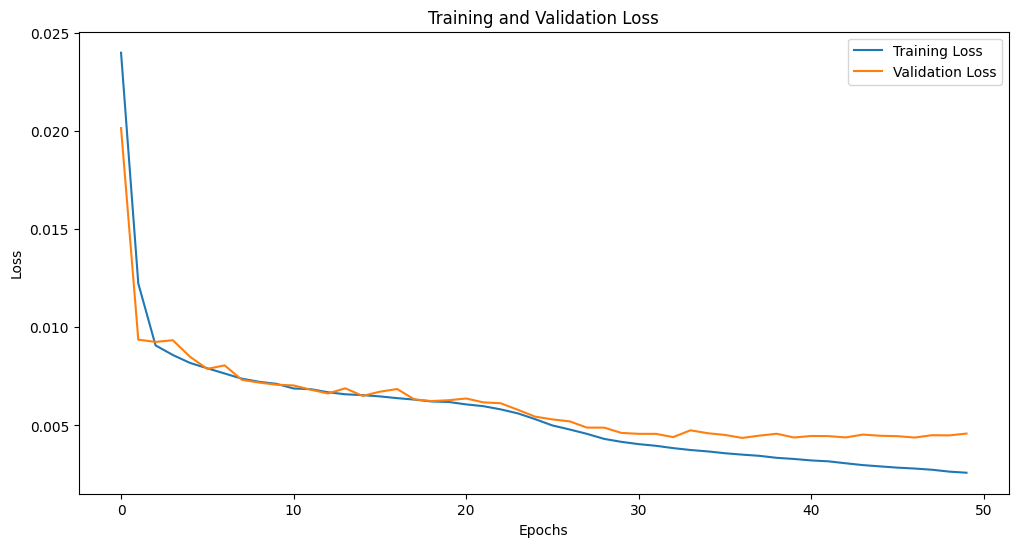

In [147]:
model_bilstm.load_weights(checkpoint4_path)

# Predict on training and test data
Y_train_pred = model_bilstm.predict(X_train_sequences)
Y_test_pred = model_bilstm.predict(X_test_sequences)

# Inverse transform predictions
Y_train_inv = scaler_Y.inverse_transform(Y_train_sequences.reshape(-1, 1))
Y_train_pred_inv = scaler_Y.inverse_transform(Y_train_pred)
Y_test_inv = scaler_Y.inverse_transform(Y_test_sequences.reshape(-1, 1))
Y_test_pred_inv = scaler_Y.inverse_transform(Y_test_pred)

# Calculate metrics
mse_train = mean_squared_error(Y_train_inv, Y_train_pred_inv)
r2_train = r2_score(Y_train_inv, Y_train_pred_inv)
mse_test = mean_squared_error(Y_test_inv, Y_test_pred_inv)
r2_test = r2_score(Y_test_inv, Y_test_pred_inv)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R² Score: {r2_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R² Score: {r2_test}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Stacking Models using LR as meta classifier

In [174]:
# Assuming you've already trained these models: model_1, model_2, model_cnn_gru, model_lstm, etc.
# X_train_sequences and X_test_sequences are the sequences for training and testing

# Generate predictions from each model
train_preds = []
test_preds = []

# Example with model_1
train_1 = model_1.predict(X_train_sequences)
train_preds.append(train_1)
test_1 = model_1.predict(X_test_sequences)
test_preds.append(test_1)

# Example with model_2
train_2 = model_2.predict(X_train_sequences)
train_preds.append(train_2)
test_2 = model_2.predict(X_test_sequences)
test_preds.append(test_2)

# Continue for other models like model_lstm, model_dense, etc.
train_preds.append(model_bilstm.predict(X_train_sequences))
test_preds.append(model_bilstm.predict(X_test_sequences))


# Convert list of predictions to numpy arrays
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)

# Reshape to (num_samples, num_models)
train_preds = train_preds.reshape(train_preds.shape[0], train_preds.shape[1])
test_preds = test_preds.reshape(test_preds.shape[0], test_preds.shape[1])

# (Optional) Flatten the arrays if needed for further processing
train_preds = train_preds.squeeze().T
test_preds = test_preds.squeeze().T

print(f"Train predictions shape: {train_preds.shape}")
print(f"Test predictions shape: {test_preds.shape}")


591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train predictions shape: (18910, 3)
Test predictions shape: (986, 3)


### Stacking Evaluation 

In [156]:
from sklearn.linear_model import LinearRegression

# Initialize the meta-model
meta_model = LinearRegression()

# Train the meta-model on the predictions of the base models
meta_model.fit(train_preds, Y_train_sequences)

# Generate final predictions using the meta-model
train_meta_preds = meta_model.predict(train_preds)
test_meta_preds = meta_model.predict(test_preds)

# Inverse transform the predictions to the original scale
train_meta_preds_inv = scaler_Y.inverse_transform(train_meta_preds.reshape(-1, 1))
test_meta_preds_inv = scaler_Y.inverse_transform(test_meta_preds.reshape(-1, 1))

# Calculate metrics
mse_train_meta = mean_squared_error(Y_train_inv, train_meta_preds_inv)
r2_train_meta = r2_score(Y_train_inv, train_meta_preds_inv)
mse_test_meta = mean_squared_error(Y_test_inv, test_meta_preds_inv)
r2_test_meta = r2_score(Y_test_inv, test_meta_preds_inv)

print(f"Meta-Model Training Mean Squared Error: {mse_train_meta}")
print(f"Meta-Model Training R² Score: {r2_train_meta}")
print(f"Meta-Model Test Mean Squared Error: {mse_test_meta}")
print(f"Meta-Model Test R² Score: {r2_test_meta}")


Meta-Model Training Mean Squared Error: 23.53234498767179
Meta-Model Training R² Score: 0.8912549175208847
Meta-Model Test Mean Squared Error: 27.28573200935874
Meta-Model Test R² Score: 0.8543312036947737


## Explainable AI

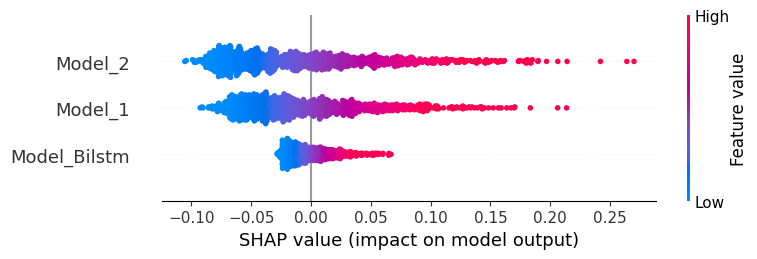

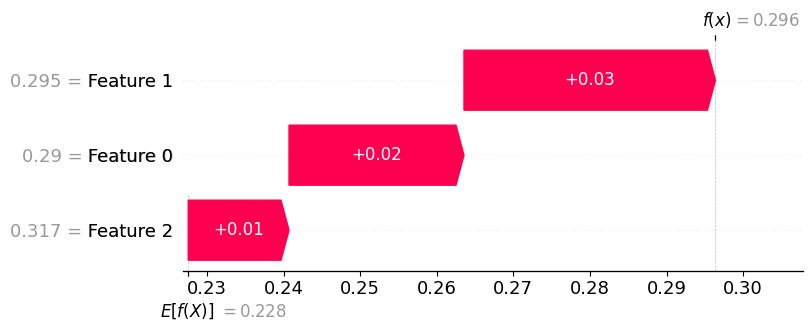

In [159]:
import shap

# Initialize the SHAP explainer
# Assuming meta_model is a scikit-learn model or a model with SHAP support
explainer = shap.Explainer(meta_model, test_preds)

# Calculate SHAP values for the test set
shap_values = explainer(test_preds)

# Summary plot for feature importance
shap.summary_plot(shap_values, test_preds, feature_names=['Model_1', 'Model_2', 'Model_Bilstm'])

# Waterfall plot for a single prediction
# Note: Waterfall plots are usually used for individual predictions; ensure index is valid
shap.plots.waterfall(shap_values[0])
